In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

%matplotlib inline

In [2]:
from importlib import reload

In [3]:
sub = pd.read_csv('McK_SubmissionFormat.csv')

In [4]:
sub.head()

,offer_gk,driver_response
0,152446,NaN
1,281031,NaN
2,779964,NaN
3,16720,NaN
4,492087,NaN


In [5]:
test = pd.read_csv('CAX_TestData_McK.csv')
train = pd.read_csv('CAX_TrainingData_McK.csv')

In [6]:
inter = set(train['order_gk']) & (set(test['order_gk']))

In [7]:
interoffers_train = [x for x in train['order_gk'] if x in inter]
interoffers_test = [x for x in test['order_gk'] if x in inter]

In [8]:
len(interoffers_train), len(interoffers_test), len(inter)

(10, 11, 7)

In [9]:
len(test['order_gk'])

237813

In [10]:
train.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [11]:
len(train[train['distance_km'] == -1])/ train.shape[0]

0.2848624793710654

In [12]:
len(train[train['driver_response'] == 1]) / train.shape[0],  train.shape[0]

(0.7402305959171235, 892557)

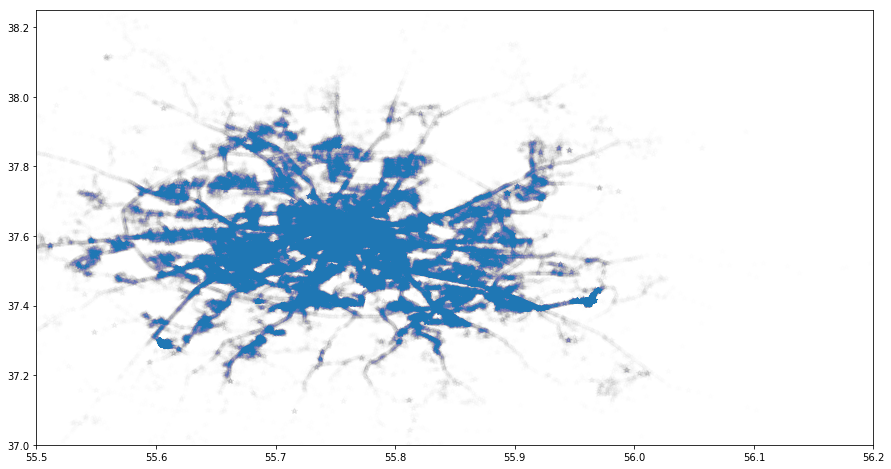

In [13]:
plt.figure(figsize=(15,8))
plt.plot(train['driver_latitude'], train['driver_longitude'], '*',alpha=0.002)
plt.xlim([55.5,56.2])
plt.ylim([37,38.25])
plt.show()

In [14]:
data = pd.concat([train, test], axis=0, ignore_index=True)

In [15]:
np.array(test.index)

array([     0,      1,      2, ..., 237810, 237811, 237812])

In [16]:
data.shape, train.shape, test.shape

((1130370, 14), (892557, 14), (237813, 14))

In [17]:
len(set(data.index)) == data.shape[0]

True

In [18]:
grouped = data.groupby(['weekday_key', 'hour_key']).count()['offer_gk']

In [19]:
pd.DataFrame(grouped).head()

offer_gk
weekday_key hour_key          
0           0             9951
            1             7501
            2             5626
            3             4478
            4             3789

In [20]:
# for i, ind in enumerate(grouped.index):
#     print(i, grouped[ind])

In [21]:
np.min([grouped[ind] for i, ind in enumerate(grouped.index)])

901

In [22]:
grouped_all = data.groupby(['weekday_key', 'hour_key'])

In [23]:
def add_dist_to_centr(df):
    center = [55.75370903771494, 37.61981338262558]
    df['driver_dist_to_centr'] = ((df['driver_latitude'] - center[0]) ** 2 + \
        (df['driver_longitude'] - center[1]) ** 2) ** 0.5
    df['origin_dist_to_centr'] = ((df['origin_order_latitude'] - center[0]) ** 2 + \
        (df['origin_order_longitude'] - center[1]) ** 2) ** 0.5
    return df

In [24]:
train.shape

(892557, 14)

In [25]:
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0.0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1.0
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0.0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1.0
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1.0


In [26]:
import gaussian_mixture_anomaly_detection

In [27]:
reload(gaussian_mixture_anomaly_detection)

<module 'gaussian_mixture_anomaly_detection' from '/Users/sergmiller/Documents/code/python/mckinzie/gaussian_mixture_anomaly_detection.py'>

In [28]:
def add_cluster_likelihood(df):
    '''
        accept ONLY non-discrete numeric columns without targets,
        df MUST have weekday_key and hour_key columns
    '''
    grouped = df.groupby(['weekday_key', 'hour_key']).count()[df.columns[4]]
    need_size = np.min([grouped[ind] for ind in grouped.index])
    df = shuffle(df, random_state=42)
    
    days = np.arange(7)
    hours = np.arange(24)
    
    times = df['weekday_key'] * 7 + df['hour_key']
    
    frames = []
    
    print('Gathering time-partitions')
    
    for day in tqdm(days, position=0):
        for hour in hours:
            frames.append(np.array(
                df[df['weekday_key'] == day][df['hour_key'] == hour].drop
                (['weekday_key', 'hour_key'],axis=1).iloc[:need_size]
            ))
    frames = np.array(frames)
    print(frames.shape)
    frames = frames.reshape((need_size, 24 * 7, -1))
    print(frames.shape)
    detector = gaussian_mixture_anomaly_detection.GaussianMixtureInTimeAnomalyDetector(
        n_components=50, tol=1e-5)
    detector.fit(frames)
    print(times.shape)
    print(df.shape)
    print(df.drop(['weekday_key', 'hour_key'],axis=1).shape)
    likelihoods = detector.predict(df.drop(['weekday_key', 'hour_key'],axis=1), times) 
    df['anomaly_ll'] = likelihoods
    df = df.sort_index()
    return df['anomaly_ll']

In [29]:
weekday_count = pd.DataFrame(train.groupby(['weekday_key']).size())
weekday_count.columns = ['weekday_overall_offers']
weekday_count['weekday_key'] = weekday_count.index
hour_count = pd.DataFrame(train.groupby(['hour_key']).size())
hour_count.columns = ['hour_overall_offers']
hour_count['hour_key'] = hour_count.index
weekday_hour_count = pd.DataFrame(train.groupby(['weekday_key', 'hour_key']).size())
weekday_hour_count.columns = ['weekday_hour_overall_offers']

def add_count_per_day_factors(df):
    df = df.join(weekday_count, on='weekday_key', lsuffix='', rsuffix='_2').drop(['weekday_key_2'], axis=1)
    df = df.join(hour_count, on='hour_key', lsuffix='', rsuffix='_2').drop(['hour_key_2'], axis=1)
    df = df.join(weekday_hour_count, on=['weekday_key', 'hour_key'], lsuffix='', rsuffix='_2')
    return df

In [30]:
y_train = train['driver_response']
X_train = train.drop(['driver_response'],axis=1)
X_test = test.drop(['driver_response'],axis=1)
X_all = data.drop(['driver_response'],axis=1)

In [31]:
X_train = add_count_per_day_factors(add_dist_to_centr(X_train))

In [32]:
X_train.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_dist_to_centr,origin_dist_to_centr,weekday_overall_offers,hour_overall_offers,weekday_hour_overall_offers
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0.292593,0.271707,155912,56451,10622
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,0.116820,0.166860,155912,40736,6972
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0.278720,0.272677,136547,40736,6475
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,0.198218,0.188961,123701,12847,1602
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,0.110147,0.109555,126882,46845,6496


In [37]:
%%time
likelihood = add_cluster_likelihood(X_train.drop(
    ['offer_gk','offer_class_group','ride_type_desc','driver_gk','order_gk'],axis=1))

  0%|          | 0/7 [00:00<?, ?it/s]

Gathering time-partitions


/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


(168, 760, 11)
(760, 168, 11)
Run fitting


/Users/sergmiller/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
  0%|          | 1/760 [00:00<02:21,  5.35it/s]

Start probabilities memorization


100%|██████████| 760/760 [02:34<00:00,  4.93it/s]


(892557,)
(892557, 13)
(892557, 11)
Normalization


  0%|          | 90/892557 [00:00<16:40, 891.69it/s]

Start prediction calc


/Users/sergmiller/Documents/code/python/mckinzie/gaussian_mixture_anomaly_detection.py:179: RuntimeWarning: divide by zero encountered in log
  for cluster in np.arange(self.n_components)]))
100%|██████████| 892557/892557 [17:20<00:00, 857.63it/s]
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 19min 31s, sys: 55 s, total: 20min 26s
Wall time: 20min 50s


In [43]:
type(likelihood)

pandas.core.series.Series

In [61]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

In [82]:
class EstimatorFitWrapper(BaseEstimator):
    def __init__(self, est, cat_features):
        self.est = est
        self.cat_features = cat_features
        
    def fit(self, X, y):
        return self.est.fit(X, y, cat_features=self.cat_features)
    
    def predict_proba(self, X):
        return self.est.predict_proba(X)

In [83]:
X_train.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_dist_to_centr,origin_dist_to_centr,weekday_overall_offers,hour_overall_offers,weekday_hour_overall_offers
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0.292593,0.271707,155912,56451,10622
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,0.116820,0.166860,155912,40736,6972
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0.278720,0.272677,136547,40736,6475
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,0.198218,0.188961,123701,12847,1602
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,0.110147,0.109555,126882,46845,6496


In [87]:
cats = ['offer_gk', 'weekday_key', 'hour_key', 
                              'driver_gk', 'order_gk', 
                              'offer_class_group', 'ride_type_desc']

ind = dict()

for i, col in enumerate(X_train.columns):
    ind[col] = i

In [104]:
%%time
res = cross_val_score(
                X=X_train,
                y=y_train,
                cv=8,
                groups=X_train['order_gk'],
                estimator = EstimatorFitWrapper(CatBoostClassifier(
                    random_seed=1, 
                    iterations=100,
                    rsm=0.3,
                    depth=7,
                    ),
                            [ind[col] for col in cats]),
                scoring='roc_auc',
                n_jobs=-1,
)
print(np.mean(res), np.std(res), res)

0.860046602559 0.0227499839489 [ 0.89927924  0.88891314  0.86483805  0.86293721  0.85054137  0.84585507
  0.84065867  0.82735008]
CPU times: user 3.92 s, sys: 1.94 s, total: 5.86 s
Wall time: 25min 1s


In [106]:
Train_exp = pd.concat((X_train, likelihood), axis=1)

In [122]:
likelihood = np.clip(likelihood,a_max=100, a_min=-20)

(array([  8.50000000e+01,   1.00000000e+00,   2.00000000e+00,
          7.00000000e+00,   3.00000000e+00,   9.00000000e+00,
          9.00000000e+00,   9.00000000e+00,   5.00000000e+00,
          1.00000000e+01,   2.30000000e+01,   3.90000000e+01,
          7.10000000e+01,   8.10000000e+01,   1.38000000e+02,
          2.20000000e+02,   3.39000000e+02,   4.54000000e+02,
          7.50000000e+02,   1.21500000e+03,   1.64300000e+03,
          2.22300000e+03,   3.01100000e+03,   4.37700000e+03,
          6.72500000e+03,   9.08900000e+03,   1.18510000e+04,
          1.55740000e+04,   1.92350000e+04,   2.29330000e+04,
          2.49170000e+04,   2.55470000e+04,   2.43710000e+04,
          2.09820000e+04,   1.62740000e+04,   1.01940000e+04,
          4.88100000e+03,   2.69100000e+03,   1.39900000e+03,
          4.72000000e+02]),
 array([-20.        , -19.46009375, -18.9201875 , -18.38028125,
        -17.840375  , -17.30046875, -16.7605625 , -16.22065625,
        -15.68075   , -15.14084374, -1

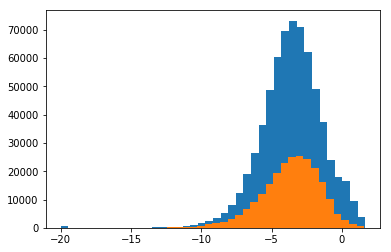

In [125]:
plt.hist([l for i,l in enumerate(likelihood) if y_train[i] == 1],bins=40)
plt.hist([l for i,l in enumerate(likelihood) if y_train[i] == 0],bins=40)

In [ ]:
plt.hist([l for i,l in enumerate(likelihood) if y_train[i] == 0],bins=40)

In [111]:
plt.hist(np.nan_to_num(Train_exp['anomaly_ll']))
plt.show()

/Users/sergmiller/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2129: RuntimeWarning: overflow encountered in subtract
  left = x - width / 2
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:436: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1918: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1941: RuntimeWarning: overflow encountered in double_scalars
  best_vmin = (_vmin // step) * step
/Users/sergmiller/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1727: RuntimeWarning: overflow encountered in double_scalars
  return (d + 1) * self._base


ValueError: Maximum allowed size exceeded

In [105]:
%%time
res = cross_val_score(
                X=pd.concat((X_train, likelihood), axis=1),
                y=y_train,
                cv=8,
                groups=X_train['order_gk'],
                estimator = EstimatorFitWrapper(CatBoostClassifier(
                    random_seed=1, 
                    iterations=100,
                    rsm=0.3,
                    depth=7,
                    ),
                            [ind[col] for col in cats]),
                scoring='roc_auc',
                n_jobs=-1,
)
print(np.mean(res), np.std(res), res)

0.85616276039 0.0232671837 [ 0.89100767  0.88842255  0.86340735  0.86191063  0.84306712  0.84617732
  0.83450638  0.82080308]
CPU times: user 4.34 s, sys: 2.57 s, total: 6.91 s
Wall time: 27min 33s


In [126]:
from sklearn.ensemble import RandomForestClassifier

In [127]:
%%time
res = cross_val_score(
                X=pd.concat((X_train, likelihood), axis=1),
                y=y_train,
                cv=8,
                groups=X_train['order_gk'],
                estimator = RandomForestClassifier(n_estimators=1000,
                                                   criterion='entropy', 
                                        max_features=0.5, max_depth=4),
                scoring='roc_auc',
                n_jobs=-1,
)
print(np.mean(res), np.std(res), res)

KeyboardInterrupt: 